# 1. MNIST 데이터 모델 학습

### [공통]
1. 모델의 layer 개수, hidden node의 개수 제한 없음.
2. activation function 또한 제한이 없음, 
   softmax함수의 경우에는 맨 끝단에만 사용.
3. dropout, batch normalization의 경우 선택 사항임. 
   모델의 test_accuracy를 높이지 못한다면 굳이 사용할 필요 없음
   
### [MNIST]
test_accuracy 99% 이상

## Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("device: gpu") if torch.cuda.is_available() else print("device: cpu")
# nvidia driver설치를 통한 gpu 인식 성공

device: gpu


## Hyper parameter setting

In [2]:
# hyper parameter setting
learning_rate = 1e-1
epochs = 100
# batch_size = 60000 # gradient descent
# batch_size = 1 # stochastic gradient descent
batch_size = 32 # mini-batch stochastic gradient descent
act = nn.Tanh()
h = 200
display_step = 10
dropout_rate = .2 # 1-% = 0.8만큼 사용 의미 

## Load data & Pre-process data

len(train_data):  60000
len(test_data):  10000
original data shape:  torch.Size([1, 28, 28])
label:  5


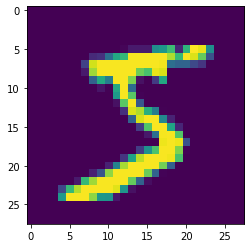

processed data shape: torch.Size([32, 1, 28, 28])
label: tensor([1, 1, 2, 1, 6, 7, 7, 1, 8, 0, 4, 1, 8, 0, 1, 5, 7, 4, 6, 6, 1, 8, 2, 4,
        2, 3, 6, 6, 6, 2, 5, 4])


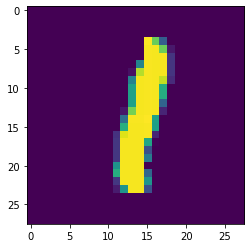

In [3]:
# load data
train_data = dataset.MNIST("./", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
test_data = dataset.MNIST("./", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('original data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10000, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('processed data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

## Modeling

In [4]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

# batchnorm + dropout in CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding =1), # 28 x 28
            nn.BatchNorm2d(16), #batch norm
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding =1), # 14 x 14 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 7 x 7
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*7*7,100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(dropout_rate), #drop out
            nn.Linear(100,10)
        )
    def forward(self, x):
        feature_extraction = self.feature_extraction(x)
        flatten = feature_extraction.view(batch_size, -1)         
        logit = self.classifier(flatten)
        
        return logit
        
model = CNN().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

## Train & Test

In [5]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())
        
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("Accuracy of the model: {}".format(correct/total))

0 epoch loss: 0.16290855407714844
10 epoch loss: 0.003077954053878784
20 epoch loss: 0.024228066205978394
30 epoch loss: 0.0020674467086791992
40 epoch loss: 0.007800966501235962
50 epoch loss: 0.005889728665351868
60 epoch loss: 0.0023231953382492065
70 epoch loss: 0.008546993136405945
80 epoch loss: 0.0013611912727355957
90 epoch loss: 9.959936141967773e-05
Accuracy of the model: 0.9917868971824646


# 2. CIFAR10 데이터 모델 학습

### [공통]
1. 모델의 layer 개수, hidden node의 개수 제한 없음.
2. activation function 또한 제한이 없음, 
   softmax함수의 경우에는 맨 끝단에만 사용.
3. dropout, batch normalization의 경우 선택 사항임. 
   모델의 test_accuracy를 높이지 못한다면 굳이 사용할 필요 없음
   
### [CIFAR10]
test_accuracy 90% 이상

## Libary

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from matplotlib import pyplot as plt
import numpy as np
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


## Hyper parameter setting

In [2]:
#hyper parameter setting
learning_rate = 1e-2
training_epochs = 200
display_step = 10
batch_size = 128
validation_ratio = 0.1

activation = nn.ReLU()
max_pool = nn.MaxPool2d(2) # kerel size, stride size, padding size 

## Load data & Pre-process data

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


len(train_data):  50000
len(test_data):  10000


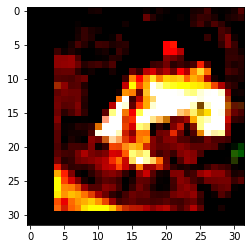

In [3]:
# compose data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# load data
train_data = dataset.CIFAR10("./data", train=True, transform=transform_train, target_transform=None, download=True)
test_data = dataset.CIFAR10("./data", train=False, transform=transform_test, target_transform=None, download=True)

# check the data
print("len(train_data): ", len(train_data))
print("len(test_data): ", len(test_data))

x_train, y_train = train_data[0]
x_train = np.transpose(x_train, (1, 2, 0))

plt.figure()
plt.imshow(x_train)
plt.show()


In [4]:
# split train date with validation set
valid_size = int(len(train_data) * validation_ratio)
train_data, valid_data = random_split(train_data, [len(train_data)-valid_size, valid_size])
print('len(train_data): ', len(train_data))
print('len(valid_data): ', len(valid_data))

train_data 길이:  45000
valid_data 길이:  5000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data shape:  torch.Size([128, 3, 32, 32])
label:  tensor(3)


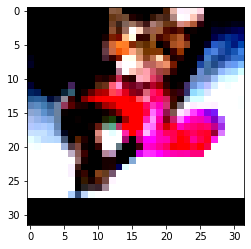

In [5]:
# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 1, drop_last = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle=True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = 1, drop_last = True)

# check the data
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print("data shape: ", example_data.shape)
print("label: ", example_target[0])

check_image = example_data[0]
check_image = np.transpose(check_image, (1, 2, 0))

plt.figure()
plt.imshow(check_image)
plt.show()

## Modeling

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # for initializing nn.Module (parent class)
        self.feature_extraction = nn.Sequential( 
            nn.Conv2d(3, 64, 3, padding=1), # number of input channel, number of output channel, kernel size 
            nn.BatchNorm2d(64),                       # we can set stride size and padding size. if we do not set the these parameters, default value is 1, 0.
            activation,
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            activation,
            max_pool,
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            activation,
            nn.Dropout(0.4),
            
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            activation,
            max_pool, 
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            activation,
            nn.Dropout(0.4),
            
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            activation,
            nn.Dropout(0.4),
            
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            activation,
            max_pool,
            
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            activation,
            nn.Dropout(0.4),
            
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            activation,
            nn.Dropout(0.4),
            
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            activation,
            max_pool,
            
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            activation,
            nn.Dropout(0.4),
            
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            activation,
            nn.Dropout(0.4),
            
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            activation,
            max_pool,
            nn.Dropout(0.5),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            activation,
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) 
        flatten = extracted_feature.view(batch_size, -1)
        result = self.classifier(flatten)
        return result
    
model = CNN().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.99)

## Train & Test

In [7]:
loss_array = []

# train the model
for i in range(training_epochs):
    scheduler.step()
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
    
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())        

/home/pirl/anaconda3/envs/project1/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


0 epoch loss: 2.111097812652588
10 epoch loss: 0.8161717057228088
20 epoch loss: 0.6456919312477112
30 epoch loss: 0.4030783474445343
40 epoch loss: 0.37220898270606995
50 epoch loss: 0.3188883066177368
60 epoch loss: 0.21205075085163116
70 epoch loss: 0.2641332149505615
80 epoch loss: 0.2145734280347824
90 epoch loss: 0.1732998937368393
100 epoch loss: 0.13840129971504211
110 epoch loss: 0.16682401299476624
120 epoch loss: 0.25426456332206726
130 epoch loss: 0.1727197766304016
140 epoch loss: 0.1420978605747223
150 epoch loss: 0.14748823642730713
160 epoch loss: 0.1512930989265442
170 epoch loss: 0.08144273608922958
180 epoch loss: 0.046271905303001404
190 epoch loss: 0.08623021095991135


In [8]:
#test the model
model.eval()
correct = 0
total = 0
    
prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(valid_loader):
        data = data.to(device)
        label = label.to(device)
            
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
            
        prediction_list.append(prediction_index)
        label_list.append(label)
            
        total += label.size(0)
        correct += (prediction_index==label).sum().float()
        
    print("Accuracy of the model: {}".format(correct/total))

Accuracy of the model: 0.9098557829856873
